In [1]:
!pip install facenet_pytorch -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [5]:
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import cv2
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

In [16]:
def compute_area(box):
    if box is None:
        return 0
    x_min, y_min, x_max, y_max = box
    return (x_max - x_min) * (y_max - y_min)

def clamp_box(box, img_width, img_height):
    x_min, y_min, x_max, y_max = box

    x_min = max(0, min(x_min, img_width - 1))
    y_min = max(0, min(y_min, img_height - 1))
    x_max = max(0, min(x_max, img_width - 1))
    y_max = max(0, min(y_max, img_height - 1))

    return [x_min, y_min, x_max, y_max]

# Function to align the image based on eye landmarks
def align_face(image, landmarks):
    # Get the left and right eye coordinates
    left_eye = landmarks[0]
    right_eye = landmarks[1]

    # Compute the angle between the eyes
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    # Compute the center of both eyes (for rotation)
    eye_center = ((left_eye[0] + right_eye[0]) // 2,
                  (left_eye[1] + right_eye[1]) // 2)

    rot_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1.0)

    # Rotate the entire image
    aligned_image = cv2.warpAffine(image, rot_matrix, (image.shape[0], image.shape[1]))

    return aligned_image, rot_matrix

# Function to apply rotation matrix to the bounding box
def rotate_box(box, rot_matrix):
    x_min, y_min, x_max, y_max = box
    corners = np.array([[x_min, y_min], [x_min, y_max], [x_max, y_min], [x_max, y_max]])

    ones = np.ones(shape=(len(corners), 1))
    corners_ones = np.hstack([corners, ones])

    transformed_corners = rot_matrix.dot(corners_ones.T).T

    x_min_new, y_min_new = np.min(transformed_corners, axis=0)[:2]
    x_max_new, y_max_new = np.max(transformed_corners, axis=0)[:2]

    return [x_min_new, y_min_new, x_max_new, y_max_new]

In [23]:
def detect_align_save(folder_name):
    img_names = os.listdir(os.path.join('/kaggle/input/webface-2/CASIA-WebFace', folder_name))
    imgs = [Image.open(os.path.join('/kaggle/input/webface-2/CASIA-WebFace', folder_name, img_name)).convert("RGB") for img_name in img_names]
    imgs = [img.resize((250, 250)) for img in imgs]
    
    # Detect faces and landmarks
    boxes, scores, landmarks = mtcnn.detect(imgs, landmarks=True)

    os.makedirs(f'/kaggle/working/CASIA-WebFace/{folder_name}', exist_ok=True)

    for img, box, landmark, img_name in zip(imgs, boxes, landmarks, img_names):
        if box is None or landmark is None:
            continue  # Skip if no faces were detected

        # Check if landmarks are detected
        if len(landmark) == 0:
            continue 

        # Perform alignment first based on eye landmarks
        aligned_image, rot_matrix = align_face(np.array(img), landmark[0])
        
        # Adjust the bounding box after rotation
        areas = [compute_area(b) for b in box]
        largest_face_idx = np.argmax(areas)
        largest_face_box = rotate_box(box[largest_face_idx], rot_matrix)

        # Clamp the bounding box within the image dimensions
        img_width, img_height = aligned_image.shape[1], aligned_image.shape[0]
        largest_face_box = clamp_box(largest_face_box, img_width, img_height)

        # Ensure the bounding box is valid (i.e., non-empty)
        x_min, y_min, x_max, y_max = map(int, largest_face_box)

        # Check if the bounding box is valid (i.e., non-empty)
        if x_max <= x_min or y_max <= y_min:
            continue

        # Extract the aligned face using the clamped bounding box
        largest_face = aligned_image[y_min:y_max, x_min:x_max]

        # Ensure largest_face is not empty
        if largest_face.size == 0:
            continue

        # Save the aligned face
        save_path = os.path.join('/kaggle/working/CASIA-WebFace', folder_name, img_name)
        Image.fromarray(largest_face).save(save_path)

In [10]:
os.makedirs('/kaggle/working/CASIA-WebFace')

In [24]:
from tqdm import tqdm

folders = os.listdir('/kaggle/input/webface-2/CASIA-WebFace/')

for folder in tqdm(folders):
    detect_align_save(folder)

100%|██████████| 10575/10575 [1:58:19<00:00,  1.49it/s] 


In [25]:
import shutil

output_path = '/kaggle/working/CASIA-WebFace'
output_tar = '/kaggle/working/CasiaWebface_detected_and_aligned.tar.gz'
shutil.make_archive(output_tar.replace('.tar.gz', ''), 'gztar', output_path)

print(f"Archive created at {output_tar}")

Archive created at /kaggle/working/CasiaWebface_detected_and_aligned.tar.gz


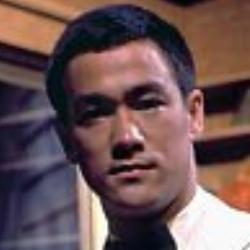

In [47]:
img = Image.open('/kaggle/input/webface-2/CASIA-WebFace/0000045/006.jpg')
img

In [48]:
boxes, scores, landmarks = mtcnn.detect(img, landmarks=True)

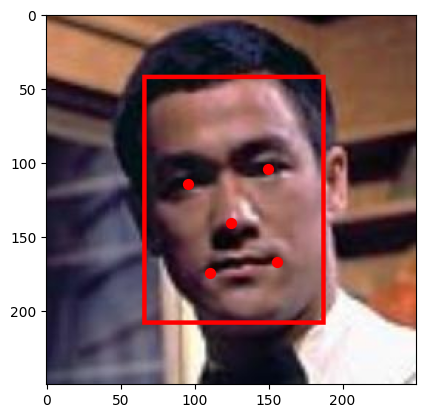

In [49]:
draw = ImageDraw.Draw(img)
draw.rectangle(boxes[0].tolist(), outline='red', width=3)

plt.imshow(np.array(img))

for i, (x, y) in enumerate(landmarks[0]):
    plt.scatter(x, y, c='red', s=50, marker='o')
        
plt.show()

How we can see. The bounding box and landmarks are valid. The detected and aligned dataset I uploaded to [https://www.kaggle.com/datasets/meln1337/casia-webface-detected-and-aligned](https://www.kaggle.com/datasets/meln1337/casia-webface-detected-and-aligned) for further use. The detected and aligned dataset will be shown more in more detail in **notebooks/** folder

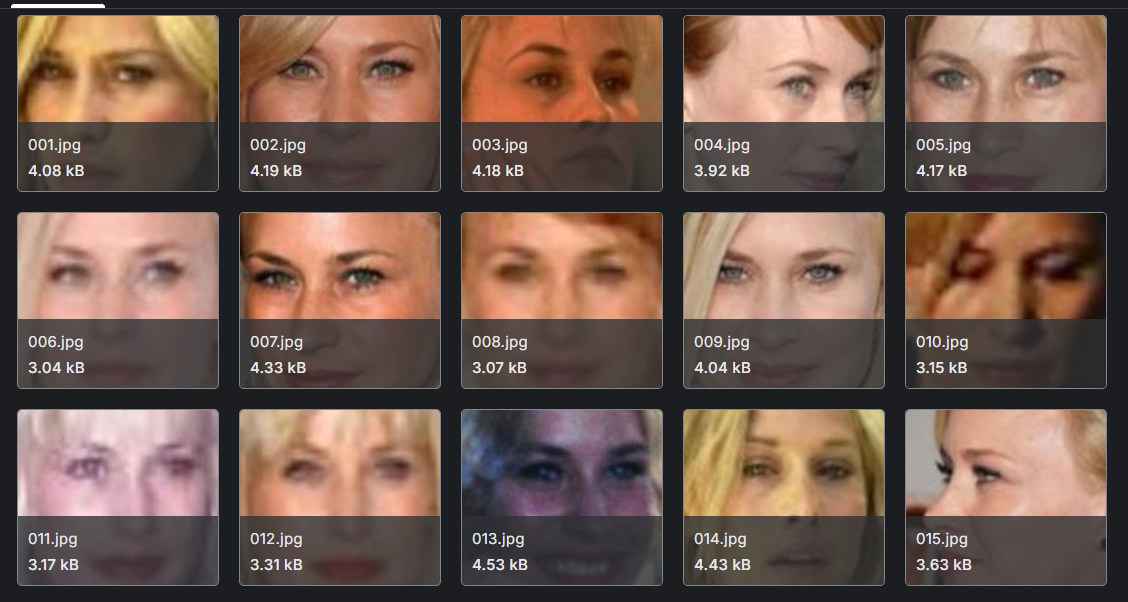

In [1]:
from IPython.display import Image
Image(filename='gifs/detected and aligned casiawebface dataset.png')